In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from   scipy import special
from   scipy import integrate
import emcee
import corner

In [2]:
C_fuv = 43.35                    # SFR to log(FUV_lumin)
mab0  = -2.5*np.log10(3631e-23)  # AB Mag zero pt
pccm  = 3.086e18                 # pc->cm conversion
c     = 2.99792458e18            # Ang/s

# Data

For estimating the cosmic SFR, I took the data (best fit Schechter parameters $M_*$,$\phi_*$,$\alpha$) for the corresponding redshifts from four different sources.

1. $z < 1$: Arnouts et. al. (2005)
2. $1<z<2.25$: Dahlen et. al.(2007)
3. $2.25<z<3.5$: Reddy & Steidel (2009)
4. $3.5<z<10$: Bouwens et. al. (2015)

In [3]:
z     = np.array([0.055,  0.3,  0.5,  0.7,  1.0, 1.14, 1.75, 2.23,  2.3, 3.05,  3.8,  4.9,  5.9,  6.8,  7.9, 10.4])
lambd = np.array([ 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1700, 1700, 1600, 1600, 1600, 1600, 1600, 1600])
nueff = c/lambd

Mstar = np.array([-18.05, -18.38, -19.49, -19.84, -20.11, -19.62, -20.24, -19.87,  
                  -20.70, -20.97, -20.88, -21.17, -20.94, -20.87, -20.63, -20.92])
Merr  = np.array([0.11,   0.25,   0.37,   0.40,   0.45,   0.06,   0.32,   0.18,    
                  0.11,   0.14,   0.08,   0.12,   0.20,   0.26,   0.36,   0.00])

phistar = np.array([4.07, 6.15, 1.69, 1.67, 1.14, 2.96, 3.11, 3.32, 
                    2.75, 1.71, 1.97, 0.74, 0.50, 0.29, 0.21, 0.008])*1e-3
phierr  = np.array([0.56, 1.76, 0.88, 0.95, 0.76, 0.15, 1.61, 0.91, 
                    0.54, 0.53, 0.32, 0.16, 0.17, 0.16, 0.17, 0.003])*1e-3

alpha = np.array([-1.21, -1.19, -1.55, -1.60, -1.63, -1.48, -1.48, -1.48, 
                  -1.73, -1.73, -1.64, -1.76, -1.87, -2.06, -2.02, -2.27])
aerr  = np.array([ 0.07,  0.15,  0.21,  0.26,  0.45,  0.62,  0.62,  0.62,  
                  0.07,  0.13,  0.04,  0.05,  0.10,  0.13,  0.23,  0.00])

In [4]:
#Convert magnitude to luminosity
Lstar = (10**-((Mstar+mab0)/2.5))*4*np.pi*(10*pccm)**2
Lerr  = (np.log(10)/2.5)*Lstar*Merr

To obtain the total UV luminosity, I computed the area under the Schecter function over the range $ 0.001 < L/L* < \infty $. It is easier to integrate the function without a dependency on $\phi_*$ or $L_*$, so I converted the integral to:
$$fuv = \int_{0.001}^{\infty} x^{\alpha+1}e^{-x} \mathrm{d}x $$

Then the area under the Schechter function is given by:
$$ L = \phi_* L_* (fuv)  $$

In [5]:
def phi(L,alpha):
    return (L**(alpha+1))*np.exp(-L)

In [6]:
fuv,err = np.zeros(np.size(z),dtype=np.float64),np.zeros(np.size(z))

for i in range(np.size(z)):
    fuv[i],err[i] = integrate.quad(phi,0.001,np.inf,args=(alpha[i]))

In [7]:
## Check if you got it right
assert(np.isclose(fuv[0],special.gamma(2+alpha[0])*special.gammaincc(2+alpha[0],0.001)))

The SFR can then be inferred from the Kennicutt(98) relation $\log{SFR} = \log{\nu L_{\nu}}-43.35$

In [8]:
logsfr = np.log10(nueff*fuv*phistar*Lstar)-C_fuv

# Error on SFR

For error estimation, I found that propagating the errors on $\alpha$ from first principles is not easy. To get an estimate of the total error due to $\alpha$, I took its two extreme values and computed the total luminosity for both the cases. The difference in the two extreme cases is the error due to $\alpha$.

The total error in the SFR is given by:
$$\sigma_{sfr}^2 = \left(\frac{\sigma_{\phi_*}}{\phi_*}\right)^2 + \left(\frac{\sigma_{L_*}}{L_*}\right)^2 + \left(\frac{\sigma_{fuv}}{fuv}\right)^2$$

In [11]:
fuvmax,fuvmin = np.zeros(np.size(z),dtype=np.float64), np.zeros(np.size(z),dtype=np.float64)

for i in range(np.size(z)):
    fuvmax[i] = integrate.quad(phi,0.001,np.inf,args=(alpha[i]-aerr[i]))[0]
    fuvmin[i] = integrate.quad(phi,0.001,np.inf,args=(alpha[i]+aerr[i]))[0]
    
fuverr = fuvmax-fuvmin

In [12]:
sfrerr = np.sqrt((phierr/phistar)**2 + (Lerr/Lstar)**2 + (fuverr/fuv)**2)

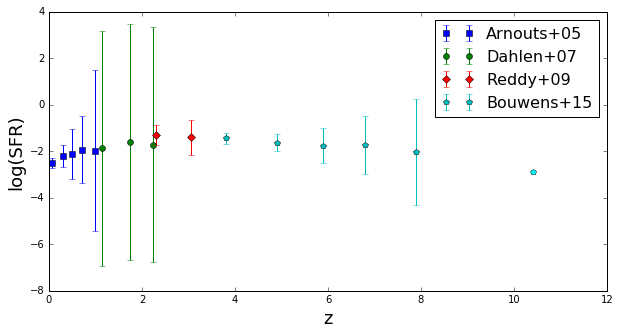

In [24]:
f,ax = plt.subplots(figsize=(10,5))
ax.errorbar(z[:5], logsfr[:5], yerr=sfrerr[:5], fmt='s',label='Arnouts+05')
ax.errorbar(z[5:8],logsfr[5:8],yerr=sfrerr[5:8],fmt='o',label='Dahlen+07')
ax.errorbar(z[8:10],logsfr[8:10],yerr=sfrerr[8:10],fmt='D',label='Reddy+09')
ax.errorbar(z[10:15], logsfr[10:15], yerr=sfrerr[10:15], fmt='p',label='Bouwens+15')
ax.plot(z[15],logsfr[15],'p',color='cyan')
ax.set_ylabel('log(SFR)',fontsize=18)
ax.set_xlabel('z',fontsize=18)
ax.legend(fontsize=16)

##### NOTE

The error bars look exactly the opposite of what I expected. I think this is because the surveys from which I took the data for low z are roughly a decade older than the survery from which I took the data for high z. Also, the data point at z~10 does not have error bars on it since $\alpha$ and $M_*$ have been assumed constant for it.

In [13]:
def lnprior(theta):
    if (0<theta[0]<5) & (2<theta[1]<4) & (0<theta[2]<10) & (0<theta[3]<10):
        return 0.0
    return -np.inf

def lnP(theta,sfh,sfherr,z):
    """Log likelihood of parameters theta=(A,B,\alpha,\gamma) given the
    SFH, the errors and z
    """
    lp = lnprior(theta)
    if not(np.isfinite(lp)):
        return -np.inf    
    A,B,alpha,gamma = theta
    #    sfh_pred = A*(1+z)**alpha/(1+((1+z)/B)**gamma)
    sfh_pred = np.log10(A*(1+z)**alpha/(1+((1+z)/B)**gamma))
    chi2 = ((sfh_pred-sfh)/sfherr)**2

    return -np.sum(chi2/2)

In [27]:
ndim,nwalkers=4,300
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnP,args=(logsfr[:-1],sfrerr[:-1],z[:-1]))

In [28]:
theta0 = np.array([np.random.rand(ndim) for i in range(nwalkers)])
# Start with the best fit values from Madau and Dickinson (eq 15)
theta0[:,0] = (0.02-0.01)*theta0[:,0]+0.01
theta0[:,1] = (4-2)*theta0[:,1]+2
theta0[:,2] = (3-2)*theta0[:,2]+2
theta0[:,3] = (6-5)*theta0[:,3]+5

# Burn-in for a bit
pos, prob, state = sampler.run_mcmc(theta0,1000)
sampler.reset()

sampler.run_mcmc(pos,1000)

(array([[  4.23436145e-03,   2.00258658e+00,   2.09447837e+00,
           1.29563137e+00],
        [  1.78829078e-03,   2.85251585e+00,   3.36402864e+00,
           5.05769013e+00],
        [  5.23492190e-03,   3.76905150e+00,   2.07533672e+00,
           2.16541285e+00],
        ..., 
        [  3.51000835e-03,   3.64859663e+00,   2.89815728e+00,
           6.31892412e+00],
        [  2.03422076e-03,   2.18467039e+00,   5.02231943e+00,
           5.59298539e+00],
        [  6.29785167e-03,   2.48604966e+00,   3.82275058e+00,
           6.04457765e+00]]),
 array([-1.11019364, -0.82991217, -1.95134007, -1.79060599, -0.42632493,
        -0.97488849, -2.0132765 , -1.61793759, -0.24931634, -2.94636406,
        -2.56666811, -0.72342788, -2.20883166, -0.88334372, -0.31653932,
        -0.30329839, -2.95382612, -1.45587856, -1.02488973, -1.02415116,
        -0.76993992, -0.48346278, -0.62144779, -2.13570278, -0.68847488,
        -1.69675278, -1.66094453, -3.69159461, -1.03990814, -2.54475084,


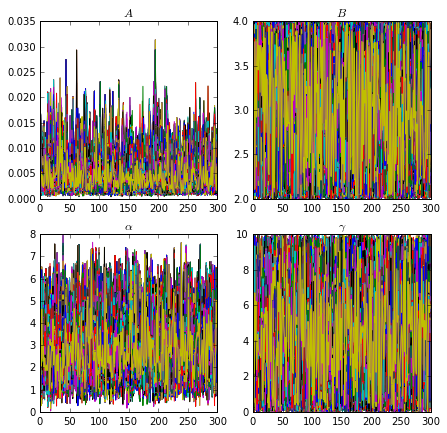

In [33]:
## Diagnostic plots
f1,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(7,7))
ax1.plot(sampler.chain[:,:,0])
ax1.set_title(r'$A$')
ax2.plot(sampler.chain[:,:,1])
ax2.set_title(r'$B$')
ax3.plot(sampler.chain[:,:,2])
ax3.set_title(r'$\alpha$')
ax4.plot(sampler.chain[:,:,3])
ax4.set_title(r'$\gamma$')

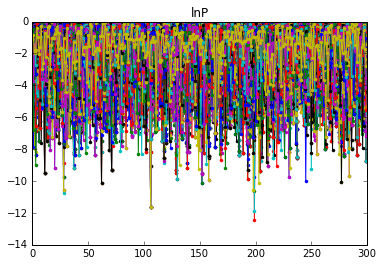

In [34]:
f2,ax5=plt.subplots(1,1)
ax5.plot(sampler.lnprobability,'.-')
ax5.set_title(r'lnP')

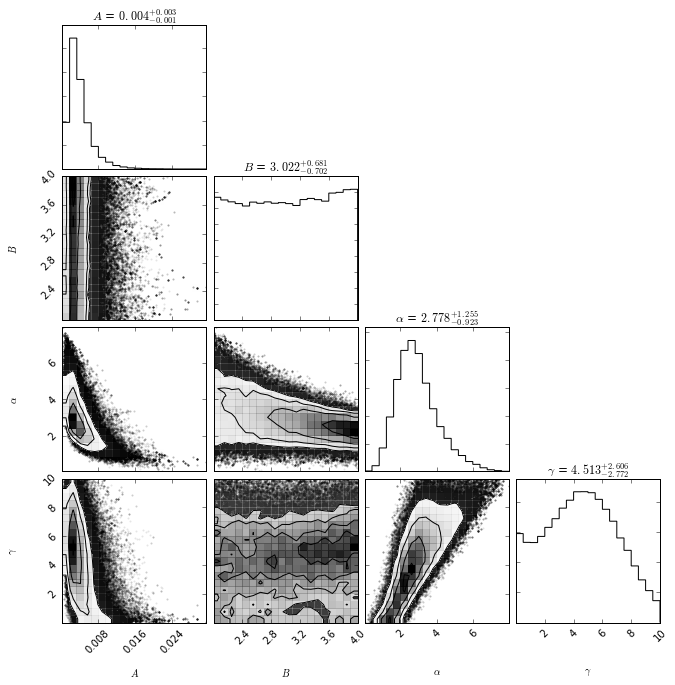

In [40]:
crnr = corner.corner(sampler.flatchain,labels=(r'$A$',r'$B$',r'$\alpha$',r'$\gamma$'),
                     show_titles=True,title_fmt='.3f')

A=0.004, B=3.02, lpha=2.778116, \gamma=4.512763


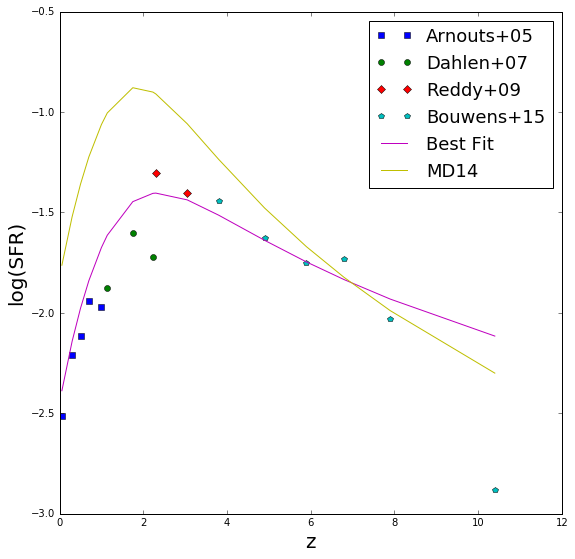

In [42]:
A = np.percentile(sampler.flatchain[:,0],50)
B = np.percentile(sampler.flatchain[:,1],50)
a = np.percentile(sampler.flatchain[:,2],50)
g = np.percentile(sampler.flatchain[:,3],50)
sfh_theo = A*(1+z)**a/(1+((1+z)/B)**g)
sfh_md = 0.015*(1+z)**2.7/(1+((1+z)/2.9)**5.6)

## Plot result of fit
f,ax = plt.subplots(1,1,figsize=(9,9))
ax.plot(z[:5], logsfr[:5],'s',label='Arnouts+05')
ax.plot(z[5:8],logsfr[5:8],'o',label='Dahlen+07')
ax.plot(z[8:10],logsfr[8:10],'D',label='Reddy+09')
ax.plot(z[10:], logsfr[10:],'p',label='Bouwens+15')
ax.plot(z,np.log10(sfh_theo),label='Best Fit')
ax.plot(z,np.log10(sfh_md),label='MD14')
ax.legend(fontsize=18)
ax.set_xlabel('z',fontsize=20)
ax.set_ylabel('log(SFR)',fontsize=20)

print ("A=%.3f, B=%.2f, \alpha=%f, \gamma=%f"%(A,B,a,g))

## Results:

Fitting the function form of equation 15 from Madau& Dickinson (2014) gave the best fit expression as:
$$ SFH = 0.004 \frac{(1+z)^{2.8}}{1+\left[(1+z)/3.02\right]^{4.5}} $$

The value of $B$ which controls the redshift of the turn-over is being pushed up-ward by my MCMC fit because the error bars on all my data points at $z\sim2$ are very large. I tried mitigating this by adding the data from Dahlen et. al (2007) but the error bars on that data also turned out to be very large. I had to manually force it to a smaller value by restricting the priors on it, hence my walkers exploring B, $\gamma$ walk around the whole parameter space without converging on a value.

The fit should certainly get better with more data points- at least around redshifts of 1-3. 

### Comparision

The MD14 fit passes well within the error bars of the data here- so it not as bad a fit as this plot makes it seem. MD14 have taken data from a lot more sources than me, so possibly their fit is a more accurate representation of reality than mine. The error bars they quote on the SFR estimates are a lot smaller than mine though, which makes me wonder if the above method is flawed in some way.